In [1]:
import numpy as np
import copy

class Parameter:
    def __init__(self, data, requires_grad=True):
        self.data = np.array(data, dtype=np.float32)
        self.grad = np.zeros_like(self.data, dtype=np.float32)
        self.requires_grad = requires_grad

class Module:
    def parameters(self):
        params = []
        visited = set()

        def visit(obj):
            if id(obj) in visited:
                return
            visited.add(id(obj))

            if isinstance(obj, Parameter):
                params.append(obj)
            elif isinstance(obj, Module):
                for v in vars(obj).values():
                    visit(v)
            elif isinstance(obj, dict):
                for v in obj.values():
                    visit(v)
            elif isinstance(obj, (list, tuple)):
                for v in obj:
                    visit(v)

        visit(self)
        return params

    def zero_grad(self):
        for p in self.parameters():
            p.grad.fill(0.0)

    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)

class Adam:
    def __init__(self, parameters, lr=0.001, beta1=0.9, beta2=0.999, eps=1e-8):
        self.parameters = parameters
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.m = [np.zeros_like(p.data) for p in self.parameters]
        self.v = [np.zeros_like(p.data) for p in self.parameters]
        self.t = 0

    def step(self):
        self.t += 1
        for i, p in enumerate(self.parameters):
            if p.grad is None:
                continue

            self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * p.grad
            self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * (p.grad ** 2)

            m_hat = self.m[i] / (1 - self.beta1 ** self.t)
            v_hat = self.v[i] / (1 - self.beta2 ** self.t)

            p.data -= self.lr * m_hat / (np.sqrt(v_hat) + self.eps)

class CrossEntropyLoss:
    def forward(self, logits, targets):
        self.logits = logits
        self.targets = targets
        B, T, V = logits.shape

        logits_flat = logits.reshape(-1, V)
        targets_flat = targets.reshape(-1)

        exps = np.exp(logits_flat - np.max(logits_flat, axis=1, keepdims=True))
        self.probs = exps / np.sum(exps, axis=1, keepdims=True)

        correct_probs = self.probs[np.arange(B*T), targets_flat]

        loss = -np.log(correct_probs + 1e-9).mean()
        return loss

    def backward(self):
        B, T, V = self.logits.shape
        grad = self.probs.copy()
        targets_flat = self.targets.reshape(-1)

        grad[np.arange(B*T), targets_flat] -= 1.0

        grad /= (B * T)

        return grad.reshape(B, T, V)

In [2]:
class Linear(Module):
    def __init__(self, in_features, out_features):
        self.W = Parameter(np.random.randn(in_features, out_features) * np.sqrt(2/in_features))
        self.b = Parameter(np.zeros(out_features))

    def forward(self, x):
        self.x = x
        return x @ self.W.data + self.b.data

    def backward(self, grad_out):

        grad_flat = grad_out.reshape(-1, grad_out.shape[-1])
        x_flat = self.x.reshape(-1, self.x.shape[-1])

        self.W.grad += x_flat.T @ grad_flat
        self.b.grad += grad_flat.sum(axis=0)

        grad_x_flat = grad_flat @ self.W.data.T
        return grad_x_flat.reshape(self.x.shape)

class LayerNorm(Module):
    def __init__(self, size, eps=1e-6):
        self.gamma = Parameter(np.ones(size))
        self.beta = Parameter(np.zeros(size))
        self.eps = eps

    def forward(self, x):
        self.x = x
        self.mean = x.mean(axis=-1, keepdims=True)
        self.var = x.var(axis=-1, keepdims=True)
        self.std = np.sqrt(self.var + self.eps)
        self.xn = (x - self.mean) / self.std
        return self.xn * self.gamma.data + self.beta.data

    def backward(self, grad_out):
        D = grad_out.shape[-1]

        self.gamma.grad += (grad_out * self.xn).sum(axis=(0, 1))
        self.beta.grad += grad_out.sum(axis=(0, 1))

        dxn = grad_out * self.gamma.data
        dx = (1 / self.std) * (
            dxn
            - dxn.mean(axis=-1, keepdims=True)
            - self.xn * (dxn * self.xn).mean(axis=-1, keepdims=True)
        )
        return dx

class Dropout(Module):
    def __init__(self, p):
        self.p = p
        self.mask = None

    def forward(self, x, training=True):
        if not training or self.p == 0.0:
            return x
        self.mask = (np.random.rand(*x.shape) > self.p).astype(np.float32)
        return x * self.mask / (1.0 - self.p)

    def backward(self, grad_out):
        if self.mask is None:
            return grad_out
        return grad_out * self.mask / (1.0 - self.p)

class Embedding(Module):
    def __init__(self, vocab_size, d_model):
        self.weight = Parameter(np.random.randn(vocab_size, d_model) * 0.1)
        self.d_model = d_model

    def forward(self, x):
        self.x = x
        return self.weight.data[x] * np.sqrt(self.d_model)

    def backward(self, grad_out):
        grad_out = grad_out * np.sqrt(self.d_model)
        np.add.at(self.weight.grad, self.x, grad_out)
        return None

In [3]:
def softmax(x):
    e = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return e / np.sum(e, axis=-1, keepdims=True)

class MultiHeadedAttention(Module):
    def __init__(self, h, d_model, dropout=0.1):
        assert d_model % h == 0
        self.d_k = d_model // h
        self.h = h
        self.W_q = Linear(d_model, d_model)
        self.W_k = Linear(d_model, d_model)
        self.W_v = Linear(d_model, d_model)
        self.W_o = Linear(d_model, d_model)
        self.dropout = Dropout(dropout)

    def forward(self, query, key, value, mask=None, training=True):
        self.mask = mask
        B = query.shape[0]

        q = self.W_q(query).reshape(B, -1, self.h, self.d_k).transpose(0, 2, 1, 3)
        k = self.W_k(key).reshape(B, -1, self.h, self.d_k).transpose(0, 2, 1, 3)
        v = self.W_v(value).reshape(B, -1, self.h, self.d_k).transpose(0, 2, 1, 3)

        self.q, self.k, self.v = q, k, v

        scores = (q @ k.swapaxes(-2, -1)) / np.sqrt(self.d_k)

        if mask is not None:
            scores = np.where(mask == 0, -1e9, scores)

        self.attn_weights = softmax(scores)
        self.attn_dropped = self.dropout(self.attn_weights, training)

        out = self.attn_dropped @ v

        out = out.transpose(0, 2, 1, 3).reshape(B, -1, self.h * self.d_k)
        return self.W_o(out)

    def backward(self, grad_out):
        B = self.q.shape[0]

        grad_out = self.W_o.backward(grad_out)
        grad_out = grad_out.reshape(B, -1, self.h, self.d_k).transpose(0, 2, 1, 3)

        dv = self.attn_dropped.swapaxes(-2, -1) @ grad_out

        d_attn = grad_out @ self.v.swapaxes(-2, -1)
        d_attn = self.dropout.backward(d_attn)

        d_scores = self.attn_weights * (d_attn - np.sum(d_attn * self.attn_weights, axis=-1, keepdims=True))
        d_scores /= np.sqrt(self.d_k)

        if self.mask is not None:
             d_scores = np.where(self.mask == 0, 0, d_scores)

        dq = d_scores @ self.k
        dk = d_scores.swapaxes(-2, -1) @ self.q

        dq = dq.transpose(0, 2, 1, 3).reshape(B, -1, self.h * self.d_k)
        dk = dk.transpose(0, 2, 1, 3).reshape(B, -1, self.h * self.d_k)
        dv = dv.transpose(0, 2, 1, 3).reshape(B, -1, self.h * self.d_k)

        d_query = self.W_q.backward(dq)
        d_key = self.W_k.backward(dk)
        d_value = self.W_v.backward(dv)

        return d_query, d_key, d_value

In [4]:
class PositionwiseFeedForward(Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        self.w_1 = Linear(d_model, d_ff)
        self.w_2 = Linear(d_ff, d_model)
        self.dropout = Dropout(dropout)

    def forward(self, x, training=True):
        self.h = np.maximum(0, self.w_1(x))
        self.h_drop = self.dropout(self.h, training)
        return self.w_2(self.h_drop)

    def backward(self, grad_out):
        grad = self.w_2.backward(grad_out)
        grad = self.dropout.backward(grad)
        grad = grad * (self.h > 0)
        return self.w_1.backward(grad)

class SublayerConnection(Module):
    def __init__(self, size, dropout):
        self.norm = LayerNorm(size)
        self.dropout = Dropout(dropout)

    def forward(self, x, sublayer):
        self.n_x = self.norm(x)
        self.sub_out = sublayer(self.n_x)
        return x + self.dropout(self.sub_out)

    def backward(self, grad_out):
        grad_residual = grad_out

        grad_sub = self.dropout.backward(grad_out)
        return grad_sub, grad_residual

In [5]:
class EncoderLayer(Module):
    def __init__(self, size, self_attn, feed_forward, dropout):
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sub1 = SublayerConnection(size, dropout)
        self.sub2 = SublayerConnection(size, dropout)

    def forward(self, x, mask, training=True):
        x = self.sub1(x, lambda n_x: self.self_attn(n_x, n_x, n_x, mask, training))
        x = self.sub2(x, lambda n_x: self.feed_forward(n_x, training))
        return x

    def backward(self, grad_out):
        g_sub, g_res = self.sub2.backward(grad_out)
        g_ff = self.feed_forward.backward(g_sub)
        grad = self.sub2.norm.backward(g_ff) + g_res

        g_sub, g_res = self.sub1.backward(grad)
        dq, dk, dv = self.self_attn.backward(g_sub)
        g_attn = dq + dk + dv
        grad = self.sub1.norm.backward(g_attn) + g_res
        return grad

class DecoderLayer(Module):
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sub1 = SublayerConnection(size, dropout)
        self.sub2 = SublayerConnection(size, dropout)
        self.sub3 = SublayerConnection(size, dropout)

    def forward(self, x, memory, src_mask, tgt_mask, training=True):
        x = self.sub1(x, lambda n_x: self.self_attn(n_x, n_x, n_x, tgt_mask, training))
        x = self.sub2(x, lambda n_x: self.src_attn(n_x, memory, memory, src_mask, training))
        x = self.sub3(x, lambda n_x: self.feed_forward(n_x, training))
        return x

    def backward(self, grad_out):
        g_sub, g_res = self.sub3.backward(grad_out)
        g_ff = self.feed_forward.backward(g_sub)
        grad = self.sub3.norm.backward(g_ff) + g_res

        g_sub, g_res = self.sub2.backward(grad)
        dq, dk, dv = self.src_attn.backward(g_sub)
        grad = self.sub2.norm.backward(dq) + g_res
        grad_memory = dk + dv

        g_sub, g_res = self.sub1.backward(grad)
        dq, dk, dv = self.self_attn.backward(g_sub)
        grad = self.sub1.norm.backward(dq + dk + dv) + g_res

        return grad, grad_memory

class Encoder(Module):
    def __init__(self, layers, norm):
        self.layers = layers
        self.norm = norm

    def forward(self, x, mask, training=True):
        for layer in self.layers:
            x = layer(x, mask, training)
        return self.norm(x)

    def backward(self, grad_out):
        grad = self.norm.backward(grad_out)
        for layer in reversed(self.layers):
            grad = layer.backward(grad)
        return grad

class Decoder(Module):
    def __init__(self, layers, norm):
        self.layers = layers
        self.norm = norm

    def forward(self, x, memory, src_mask, tgt_mask, training=True):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask, training)
        return self.norm(x)

    def backward(self, grad_out):
        grad = self.norm.backward(grad_out)
        grad_memory_total = None

        for layer in reversed(self.layers):
            grad, grad_mem_layer = layer.backward(grad)
            if grad_memory_total is None:
                grad_memory_total = grad_mem_layer
            else:
                grad_memory_total += grad_mem_layer

        return grad, grad_memory_total

In [6]:
class PositionalEncoding(Module):
    def __init__(self, d_model, dropout, max_len=5000):
        self.dropout = Dropout(dropout)
        pe = np.zeros((max_len, d_model))
        position = np.arange(max_len)[:, np.newaxis]
        div_term = np.exp(np.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))

        pe[:, 0::2] = np.sin(position * div_term)
        pe[:, 1::2] = np.cos(position * div_term)
        self.pe = pe

    def forward(self, x, training=True):
        self.x_len = x.shape[1]
        x = x + self.pe[:x.shape[1]]
        return self.dropout(x, training)

    def backward(self, grad_out):
        return self.dropout.backward(grad_out)

class Generator(Module):
    def __init__(self, d_model, vocab):
        self.proj = Linear(d_model, vocab)

    def forward(self, x):
        return self.proj(x)

    def backward(self, grad_out):
        return self.proj.backward(grad_out)

class Transformer(Module):
    def __init__(self, encoder, decoder, src_embed, tgt_embed, pos_enc_src, pos_enc_tgt, generator):
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.pos_enc_src = pos_enc_src
        self.pos_enc_tgt = pos_enc_tgt
        self.generator = generator

    def forward(self, src, tgt, src_mask, tgt_mask, training=True):
        src_emb = self.pos_enc_src(self.src_embed(src), training)
        memory = self.encoder(src_emb, src_mask, training)

        tgt_emb = self.pos_enc_tgt(self.tgt_embed(tgt), training)
        dec_out = self.decoder(tgt_emb, memory, src_mask, tgt_mask, training)

        return self.generator(dec_out)

    def backward(self, grad_logits):
        grad_dec_out = self.generator.backward(grad_logits)

        grad_tgt_emb, grad_memory = self.decoder.backward(grad_dec_out)

        grad_src_emb = self.encoder.backward(grad_memory)

        self.pos_enc_tgt.backward(grad_tgt_emb)
        self.tgt_embed.backward(grad_tgt_emb)

        self.pos_enc_src.backward(grad_src_emb)
        self.src_embed.backward(grad_src_emb)

def make_model(src_vocab, tgt_vocab, N=2, d_model=64, d_ff=128, h=4, dropout=0.1):
    c = copy.deepcopy

    def get_attn(): return MultiHeadedAttention(h, d_model, dropout)
    def get_ff(): return PositionwiseFeedForward(d_model, d_ff, dropout)

    enc_layers = [EncoderLayer(d_model, get_attn(), get_ff(), dropout) for _ in range(N)]
    dec_layers = [DecoderLayer(d_model, get_attn(), get_attn(), get_ff(), dropout) for _ in range(N)]

    model = Transformer(
        Encoder(enc_layers, LayerNorm(d_model)),
        Decoder(dec_layers, LayerNorm(d_model)),
        Embedding(src_vocab, d_model),
        Embedding(tgt_vocab, d_model),
        PositionalEncoding(d_model, dropout),
        PositionalEncoding(d_model, dropout),
        Generator(d_model, tgt_vocab)
    )

    return model

def subsequent_mask(size):
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return (subsequent_mask == 0)

In [22]:
def generate_batch(batch_size, length, vocab_size):
    data = np.random.randint(1, vocab_size, size=(batch_size, length))

    targets = data[:, ::-1]

    sos = np.zeros((batch_size, 1), dtype=np.int32)

    src = data
    tgt_in = np.concatenate([sos, targets], axis=1)
    tgt_out = targets

    return src, tgt_in, tgt_out

src, tgt_in, tgt_out = generate_batch(batch_size=2, length=5, vocab_size=10)
print(f"Source:  {src[0]}")
print(f"Target:  {tgt_out[0]}")

Source:  [9 4 8 6 9]
Target:  [9 6 8 4 9]


In [27]:
src, tgt_in, tgt_out

(array([[9, 4, 8, 6, 9],
        [6, 4, 3, 7, 2]]),
 array([[0, 9, 6, 8, 4, 9],
        [0, 2, 7, 3, 4, 6]]),
 array([[9, 6, 8, 4, 9],
        [2, 7, 3, 4, 6]]))

In [11]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):

    src_emb = model.pos_enc_src(model.src_embed(src), training=False)
    memory = model.encoder(src_emb, src_mask, training=False)

    ys = np.ones((1, 1), dtype=np.int32) * start_symbol

    for i in range(max_len - 1):
        tgt_mask = subsequent_mask(ys.shape[1])

        tgt_emb = model.pos_enc_tgt(model.tgt_embed(ys), training=False)
        out = model.decoder(tgt_emb, memory, src_mask, tgt_mask, training=False)

        prob = model.generator(out[:, -1])

        next_word = np.argmax(prob, axis=-1)
        next_word = next_word.reshape(1, 1)

        ys = np.concatenate([ys, next_word], axis=1)

    return ys

Step 000 | Loss: 3.3044
Step 050 | Loss: 2.1040
Step 100 | Loss: 1.9920
Step 150 | Loss: 1.9570
Step 200 | Loss: 1.8418
Step 250 | Loss: 1.7103
Step 300 | Loss: 1.6377
Step 350 | Loss: 1.3796
Step 400 | Loss: 1.3372
Step 450 | Loss: 1.2209
Step 500 | Loss: 1.0197
Step 550 | Loss: 0.7844
Step 600 | Loss: 0.7701
Step 650 | Loss: 0.6370
Step 700 | Loss: 0.6899
Step 750 | Loss: 0.6039
Step 800 | Loss: 0.4138
Step 850 | Loss: 0.5629
Step 900 | Loss: 0.6360
Step 950 | Loss: 0.3699


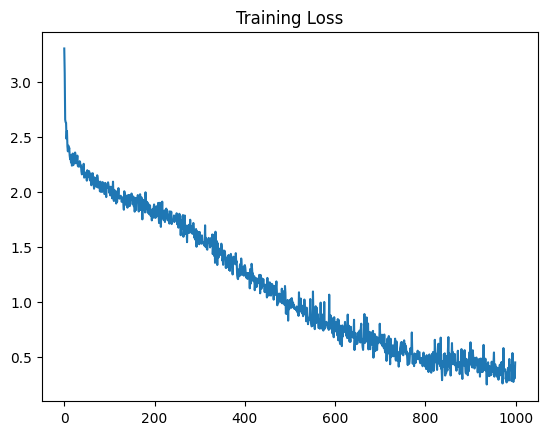

In [13]:
V = 11
LEN = 10
D_MODEL = 64
N_LAYERS = 2
H = 4
BATCH_SIZE = 16
STEPS = 1000

model = make_model(src_vocab=V, tgt_vocab=V, N=N_LAYERS, d_model=D_MODEL, h=H, dropout=0.1)
optimizer = Adam(model.parameters(), lr=0.001)
criterion = CrossEntropyLoss()

losses = []

for step in range(STEPS):
    src, tgt_in, tgt_out = generate_batch(BATCH_SIZE, LEN, V)

    model.zero_grad()

    logits = model(
        src,
        tgt_in,
        src_mask=None,
        tgt_mask=subsequent_mask(tgt_in.shape[1]),
        training=True
    )

    logits_pred = logits[:, :LEN, :]
    loss = criterion.forward(logits_pred, tgt_out)
    losses.append(loss)

    grad_logits = criterion.backward()

    grad_padded = np.zeros_like(logits)
    grad_padded[:, :LEN, :] = grad_logits

    model.backward(grad_padded)

    optimizer.step()

    if step % 50 == 0:
        print(f"Step {step:03d} | Loss: {loss:.4f}")

import matplotlib.pyplot as plt
plt.plot(losses)
plt.title("Training Loss")
plt.show()

In [21]:
test_src, _, test_tgt = generate_batch(batch_size=1, length=LEN, vocab_size=V)

print(f"Input:   {test_src[0]}")
print(f"Expected: {test_tgt[0]}")

pred_seq = greedy_decode(model, test_src, src_mask=None, max_len=LEN+1, start_symbol=0)

print(f"Prediction: {pred_seq[0, 1:]}")

if np.array_equal(test_tgt[0], pred_seq[0, 1:]):
    print("\nSUCCESS")
else:
    print("\nFAILURE")

Input:   [1 8 4 4 6 3 7 4 7 2]
Expected: [2 7 4 7 3 6 4 4 8 1]
Prediction: [2 7 4 7 3 6 4 4 8 1]

SUCCESS
